# OISSTv2 Live Updating Workflow

This notebook is for documenting the steps to build a single annual OISSTv2 file using update caches. The processing of global anomalies, and the regional timelines that we keep on hand for analyses. 

The steps were developed initially in `Update_01_Download_OISST` then the steps were abstracted into functions and placed into the `oisstools.py` module. This notebook will follow the same steps but with much less code, hopefully with less room for error.

This notebook exists to document the processing steps, but has since been replaced by script workflows using prefect in `oisst_prefect.py`. Use this notebook for debugging or extending the workflow, then transfer to `oisst_prefect.py`

In [1]:
# Libraries
from bs4 import BeautifulSoup
import requests
import os
import xarray as xr
import datetime
import oisstools as ot


#### 1. Set workspace
workspace = "local"
box_root = ot.set_workspace("local")
_cache_root = ot.set_cache_root(box_root)

# Manual Months
# this_month = "09"
# ast_month = "08"


#### 2. What Months are we checking?
this_month = ot.get_update_month(return_this_month = True)
last_month = ot.get_update_month(return_this_month = False)
update_yr  = ot.check_update_yr(for_this_month = True)


#### 3. Print Last Update
print(f"Working via directory at: {box_root}")
print(f"Updated using months:     {last_month} & {this_month}")

Working via directory at: /Users/akemberling/Box/
Updated using months:     10 & 11


## 1. Download Daily Files for Last Month

In [2]:
# Use cache_oisst function to update cache for last month
ot.cache_oisst(cache_month = last_month, 
               update_yr = update_yr, 
               workspace = workspace, 
               verbose = True)

Caching Daily NETCDF File: oisst-avhrr-v02r01.20211001.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211002.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211003.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211004.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211005.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211006.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211007.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211008.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211009.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211010.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211011.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211012.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211013.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211014.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211015.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211016.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211017.nc
Caching Daily 

## 2. Download Daily Files for This Month

In [3]:
# Use cache_oisst function to update cache for last month
ot.cache_oisst(cache_month = this_month, 
               update_yr = update_yr, 
               workspace = workspace, 
               verbose = True)

Caching Daily NETCDF File: oisst-avhrr-v02r01.20211101_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211102_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211103_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211104_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211105_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211106_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211107_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20211108_preliminary.nc
Current month preliminary data found for: 20211101
Current month preliminary data found for: 20211102
Current month preliminary data found for: 20211103
Current month preliminary data found for: 20211104
Current month preliminary data found for: 20211105
Current month preliminary data found for: 20211106
Current month preliminary data found for: 20211107
Current month preliminary data found for: 20211108
Prelim and Finalized Data Found 

## 3. Build Annual File

In [4]:
# Assemble the annual file
oisst_update = ot.build_annual_from_cache(last_month = last_month, 
                                          this_month = this_month, 
                                          workspace = workspace, 
                                          verbose = True)

## 4. Check Annual file

Want to see consistency in the dimensions, and data from the beginning of the year through to the update month.

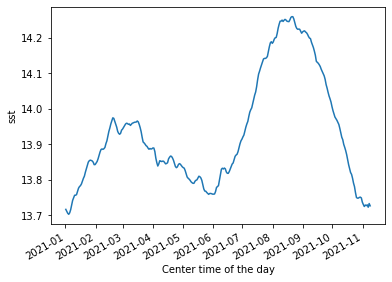

In [5]:
#oisst_update
oisst_update.sst.mean(("lon", "lat")).plot()

## 5. Export Update

In [6]:
# export update using same file pattern as everything else
ot.export_annual_update(cache_root = _cache_root,
                        update_yr = update_yr,
                        oisst_update = oisst_update)

File Saved to /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.2021.v2.nc


## 6. Update Annual Anomalies

In [7]:
# Specify year range to update
yr_min = 2021
yr_max = 2021
print(f"Updating Year(s): {yr_min} - {yr_max}")

# Set desired climatology period
reference_period = "1982-2011"
print(f"Calculating Anomalies for {reference_period} reference period.")

# Run Global Anomalies
ot.update_global_anomalies(yr_min = yr_min, 
                           yr_max = yr_max, 
                           box_root = box_root, 
                           var_name = "sst", 
                           reference_period = "1982-2011")

Updating Year(s): 2021 - 2021
Calculating Anomalies for 1982-2011 reference period.
Saving anomaly year: 2021


## 7. Update Global Timeseries

In [8]:
ot.update_global_timeseries(yr_min, yr_max, box_root, var_name = "sst", reference_period = "1982-2011")

Updating Global Timeseries


## 8. Regional timeseries 

In [9]:
# start and end years for the update
start_yr = 2021
end_yr   = 2021
print(f"Updating Regional Timeseries for: {start_yr} - {end_yr}")

# variable name to mask and make timeline from
var_name = "sst"

# GMRI Focal Areas
ot.update_regional_timeseries_collection(start_yr = start_yr, end_yr = end_yr, region_collection = "gmri_sst_focal_areas", box_root = box_root)

# Northeast Marine Regions
ot.update_regional_timeseries_collection(start_yr = start_yr, end_yr = end_yr, region_collection = "nelme_regions", box_root = box_root)

# NMFS Trawl Regions
ot.update_regional_timeseries_collection(start_yr = start_yr, end_yr = end_yr, region_collection = "nmfs_trawl_regions", box_root = box_root)

# Gulf of Maine Physio Regions
ot.update_regional_timeseries_collection(start_yr = start_yr, end_yr = end_yr, region_collection = "gom_physio_regions", box_root = box_root)

# Large Marine Ecosystems
ot.update_regional_timeseries_collection(start_yr = start_yr, end_yr = end_yr, region_collection = "lme", box_root = box_root)

Updating Regional Timeseries for: 2021 - 2021
Updating Timeseries for: gmri_sst_focal_areas
Updating Timeseries for:
 - apershing_gulf_of_maine
 - cpr_gulf_of_maine
 - aak_northwest_atlantic
 - long_island_sound
Updating Timeseries for: nelme_regions
Updating Timeseries for:
 - GoM
 - NELME
 - SNEandMAB
Updating Timeseries for: nmfs_trawl_regions
Updating Timeseries for:
 - georges_bank
 - gulf_of_maine
 - southern_new_england
 - mid_atlantic_bight
 - inuse_strata
 - regions_collection
Updating Timeseries for: gom_physio_regions
Updating Timeseries for:
 - bay_of_fundy
 - bear_seamount
 - browns_bank
 - central_gulf_of_maine
 - continental_slope
 - eastern_coastal_shelf
 - georges_bank
 - georges_basin
 - jordan_basin
 - kelvin_seamount
 - manning_seamount
 - northern_coastal_shelf
 - scotian_coastal_shelf
 - scotian_shelf
 - southern_coastal_shelf
 - wikinson_basin
Updating Timeseries for: lme
Updating Timeseries for:
 - agulhas_current
 - aleutian_islands
 - antarctica
 - arabian_sea

# 9. Make Monthly Files

In [33]:
# Load all the daily files we have
oisst_temp_daily = ot.load_box_oisst(box_root, start_yr = 1981, end_yr = update_yr, anomalies = False, do_parallel = True)
oisst_anoms_daily = ot.load_box_oisst(box_root, start_yr = 1981, end_yr = update_yr, anomalies = True, do_parallel = True)

# Use resample to get monthly averages for each year - keeps index of time
oisst_months = oisst_temp_daily.resample(time = "1M").mean(dim = "time")
anom_months = oisst_anoms_daily.resample(time = "1M").mean(dim = "time")
# oisst_months.sst.isel(time = 5).plot()
# anom_months.sst.isel(time = 5).plot()

# Combine to same Dataset
month_tidy = xr.merge([oisst_months, anom_months.rename({"sst": "sst_anom"})])

# Set Attributes: TBD

# Save out monthly netcdf
out_path = f'{box_root}RES_Data/OISST/oisst_mainstays/monthly_averages/oisst_monthly.nc'
month_tidy.to_netcdf(out_path)
print("Saving Monthly Averages")

,Array,Chunk
Bytes,2.00 GB,4.15 MB
Shape,"(483, 720, 1440)","(1, 720, 1440)"
Count,2538 Tasks,483 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.00 GB,4.15 MB
Shape,"(483, 720, 1440)","(1, 720, 1440)"
Count,2538 Tasks,483 Chunks
Type,float32,numpy.ndarray


/Users/akemberling/opt/anaconda2/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Saving Monthly Averages
